# Capstone Storytelling Writeup

#### Springboard Data Science Career Track
##### Tamara Monge

Link to dataset: https://data.baltimorecity.gov/Transportation/Parking-Citations/n4ma-fj3m

I have grouped the questions I've asked in this investigation according to what they reveal. 

For instance, regarding the offenses themselves, what types of offenses are committed? Which are the most common offenses? And what are the amounts of the fines?

With regard to the incidents themselves, when do the incidents take place? Which month of the year is most common? Which hour of the day is most common? 

And with regard to the offenders, which vehicles commit the most offenses? From which state are the most offenses committed? 

Concerning the status of the accounts, are there open balances or additional fines? If so, what are they? How common is it for a penalty to be issued for late payment? 

Next, with regard to the volume of citations, on average how many citations are issued per day, per month, per year?

Finally, with regard to city revenue, on average how much money does the city make off of parking citations, per day, per month, per year?

Below is the code used to ask these questions and resulting visualizations illustrating the answers.  

### Prelude: importing and cleaning the data (for detailed explanation of this section see: DataWrangling_Writeup)

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

df_full = pd.read_csv('/Users/tami/Documents/Springboard/Capstone1/Parking_Citations.csv')

df_full['ViolDate'] = df_full['ViolDate'][pd.notnull(df_full['ViolDate'])].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'))
df = df_full[:][df_full['ViolDate'] >= '2015-09-23']

df.drop(['ExpMM', 'ExpYY', 'PenaltyDate', 'NoticeDate', 'ImportDate', 'Neighborhood', 'PoliceDistrict', 'CouncilDistrict'], axis=1, inplace=True)

df['year']  = df['ViolDate'][pd.notnull(df['ViolDate'])].dt.year.astype(int)
df['month'] = df['ViolDate'][pd.notnull(df['ViolDate'])].dt.month.astype(int)
df['day']   = df['ViolDate'][pd.notnull(df['ViolDate'])].dt.day.astype(int)
df['hour']  = df['ViolDate'][pd.notnull(df['ViolDate'])].dt.hour.astype(int)

df['ViolFine']    = df['ViolFine'][df['ViolFine'].apply(type) == str].apply(lambda x: x[1:]).astype(float) 
df['Balance']     = df['Balance'][df['Balance'].apply(type) == str].apply(lambda x: x[1:]).astype(float)   
df['OpenFine']    = df['OpenFine'][df['OpenFine'].apply(type) == str].apply(lambda x: x[1:]).astype(float)   
df['OpenPenalty'] = df['OpenPenalty'][df['OpenPenalty'].apply(type) == str].apply(lambda x: x[1:]).astype(float)

df['Address'] = df['Address'].str.upper()
df['State'] = df['State'].str.upper()
df['Make']  = df['Make'].str.upper()
df['Make']  = df['Make'][df['Make'].apply(type) == str].apply(lambda x: x[:3]) 

def latitude(location):
    """Ingest Location and return latitude"""
    lat = float('NaN')
    if type(location) == str:
        if ((len(location.split('\n')) > 2) and (location.split('\n')[2] != '')):
            lat = float(location.split('\n')[2].split('(')[1].split(',')[0])
    return lat


def longitude(location):
    """Ingest Location and return longitude"""
    lon = float('NaN')
    if type(location) == str:
        if ((len(location.split('\n')) > 2) and (location.split('\n')[2] != '')):
            lon = float(location.split('\n')[2].split('(')[1].split(',')[1].split(')')[0])       
    return lon


def street_address(location):
    """Ingest Location and return street address"""
    address = ''
    if type(location) == str and len(location.split('\n')) >=1 :
        address = location.split('\n')[0]       
    return address


def latlon(location):
    """Ingest Location and return tuple of latitude, longitude"""
    latlon = ''
    if type(location) == str and ((len(location.split('\n')) > 2) and (location.split('\n')[2] != '')):
            latlon = (location.split('\n')[2])
    return latlon


df['latitude']       = df['Location'].apply(latitude)
df['longitude']      = df['Location'].apply(longitude)
df['street_address'] = df['Location'].apply(street_address)
df['latlon']         = df['Location'].apply(latlon)

df.index = df['ViolDate']
df.drop('ViolDate', axis=1, inplace=True)

df.dropna(axis=0, how='any', subset=['Citation', 'Tag', 'State', 'Make', 'Address', 'ViolCode', 'Description', 'ViolFine', 'Balance', 'OpenFine', 'OpenPenalty', 'Location', 'year', 'month', 'day', 'hour', 'street_address'], inplace=True)

address_latlon = zip(df['Address'], df['latlon'])
address_dict = dict(address_latlon)
df['new_latlon'] = df['Address'].map(address_dict)

df = df[['Citation','Tag', 'State', 'Make', 'year', 'month', 'day', 'hour', 'ViolCode', 'Description', 'Address','new_latlon', 'latitude', 'longitude',  'ViolFine', 'Balance', 'OpenFine', 'OpenPenalty']]
df.columns =['citation', 'tag', 'state', 'make', 'year', 'month', 'day', 'hour', 'code', 'description', 'address', 'latlon', 'latitude', 'longitude', 'fine', 'balance', 'open_fine', 'open_penalty']

/Users/tami/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### (A) The Offenses - Description and Fine

31.170902058280458

12.546446998234376

10.188777839579913

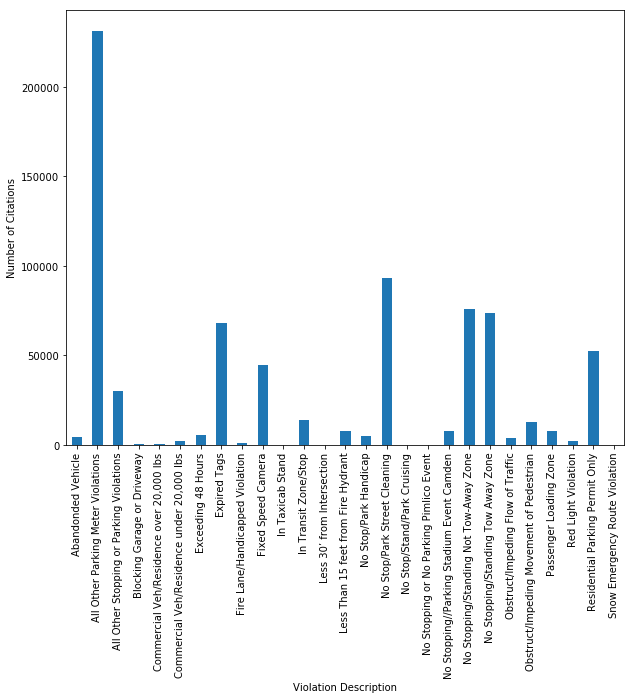

In [2]:
df['description'][df['description'] == 'All Other Parking Meter Violations'].count()/df['code'].count()*100 
df['description'][df['description'] == 'No Stop/Park Street Cleaning'].count()/df['code'].count()*100  
df['description'][df['description'] == 'No Stopping/Standing Not Tow-Away Zone'].count()/df['code'].count()*100  

fig = plt.figure(figsize=(10,8))
_ = df['description'].value_counts().sort_index().plot(kind='bar')
_ = plt.xlabel('Violation Description')
_ = plt.ylabel('Number of Citations')

Findings:
- There were 27 unique violation descriptions. 
- The most common violation was "All Other Parking Meter Violations,"(31%), followed by "No Stop/Park Street Cleaning" (13%), and "No Stopping/Standing Not Tow-Away Zone" (10%).

count    742513.000000
mean         47.129413
std          46.454321
min          23.000000
25%          32.000000
50%          32.000000
75%          52.000000
max         502.000000
Name: fine, dtype: float64

56.342986587440222

62.312713716796878

96.973925035655938

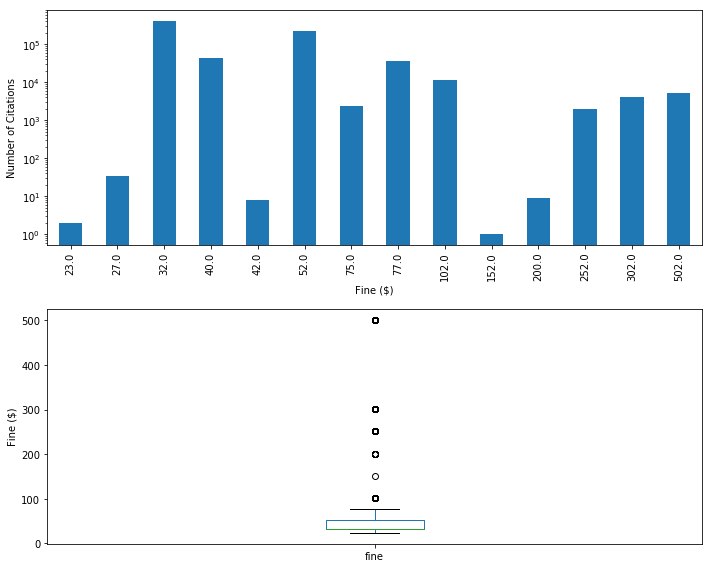

In [3]:
df['fine'].describe()
df['fine'][df['fine'] == 32].count()/df['fine'].count()*100
df['fine'][df['fine'] < 50 ].count()/df['fine'].count()*100
df['fine'][df['fine'] < 100 ].count()/df['fine'].count()*100

fig = plt.figure(figsize=(10, 8))
_ = plt.subplot(2,1,1)
_ = df['fine'].value_counts().sort_index().plot(kind='bar')
_ = plt.xlabel('Fine ($)')
_ = plt.ylabel('Number of Citations')
_ = plt.yscale('log')
_ = plt.subplot(2,1,2)
_ = df['fine'].plot(kind='box')
_ = plt.ylabel('Fine ($)')
_ = plt.tight_layout()

Findings:
- The minimum fine is \$23 and the maximum fine is \$502.
- The most common fine amount is \$32 (56%).
- 62% of fines are less than \$50.
- 97% of fines are less than \$100. 

### (B) The Incidents - Date and Time 

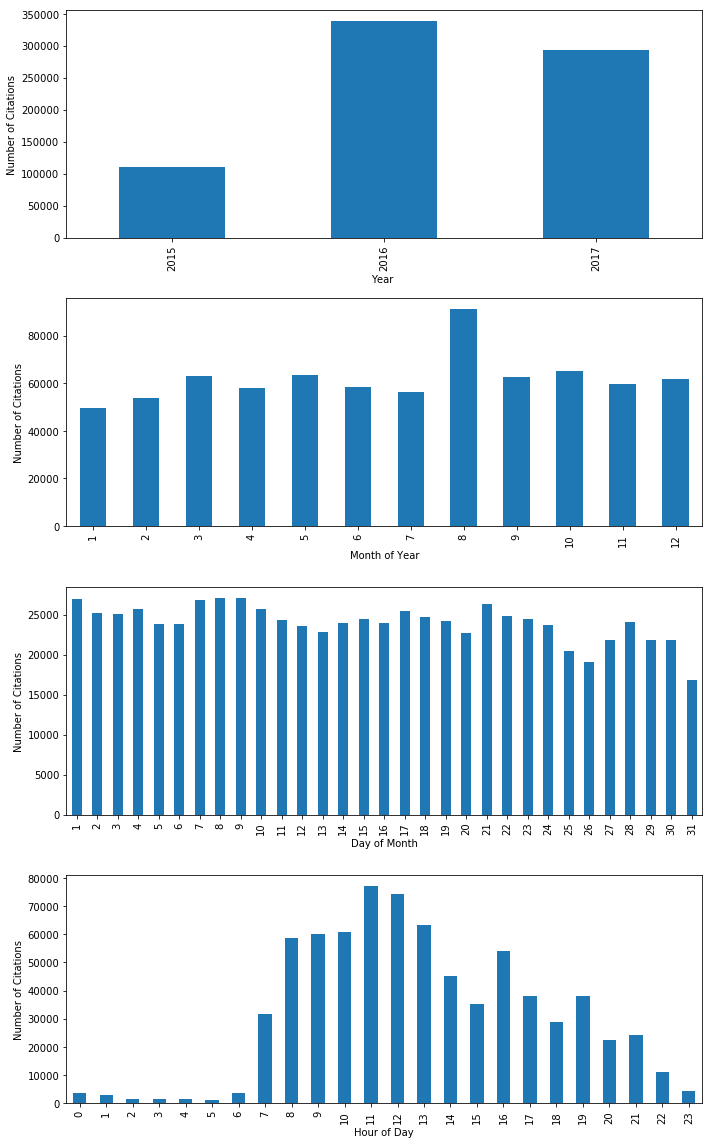

In [4]:
fig = plt.figure(figsize=(10, 16))
_ = plt.subplot(4,1,1)
_ = df['year'].value_counts().sort_index().plot(kind='bar')
_ = plt.xlabel('Year ')
_ = plt.ylabel('Number of Citations')
_ = plt.subplot(4,1,2)
_ = df['month'].value_counts().sort_index().plot(kind='bar')
_ = plt.xlabel('Month of Year')
_ = plt.ylabel('Number of Citations')
_ = plt.subplot(4,1,3)
_ = df['day'].value_counts().sort_index().plot(kind='bar')
_ = plt.xlabel('Day of Month')
_ = plt.ylabel('Number of Citations')
_ = plt.subplot(4,1,4)
_ = df['hour'].value_counts().sort_index().plot(kind='bar')
_ = plt.xlabel('Hour of Day')
_ = plt.ylabel('Number of Citations')
_ = plt.tight_layout()

Findings: 
- The month that sees the most citations is August. 
- The hour that sees the most citations is 11:00-12:00.

### (C) The Offenders  - Vehicle Make and State

count     742513
unique       344
top          HON
freq       94412
Name: make, dtype: object

12.715198252421169

12.279650322620613

10.474294726152943

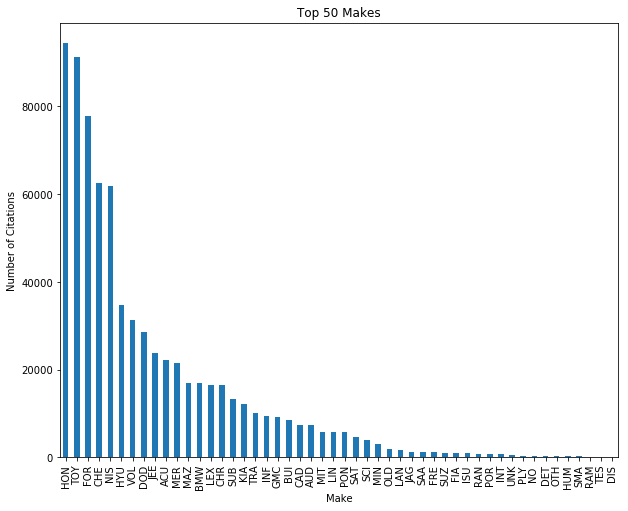

In [5]:
df['make'].describe()  
df['make'][df['make'] == 'HON'].count()/df['make'].count()*100
df['make'][df['make'] == 'TOY'].count()/df['make'].count()*100
df['make'][df['make'] == 'FOR'].count()/df['make'].count()*100

fig = plt.figure(figsize=(10,8))
_ = df['make'].value_counts().sort_values(ascending=False).head(50).plot(kind='bar')
_ = plt.xlabel('Make')
_ = plt.ylabel('Number of Citations')
_ = plt.title('Top 50 Makes')

Findings:
- 344 unique car makes received citations.
- The most common make to receive citations was HONDA (12.7%), followed by TOYOTA (12.3%), and FORD (10.5%).

count     742513
unique        86
top           MD
freq      626850
Name: state, dtype: object

84.422764315237572

2.6206948565210308

2.5472954682274924

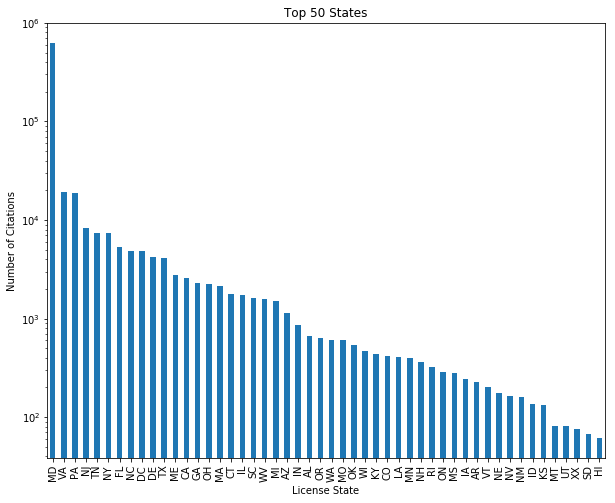

In [6]:
df['state'].describe()  
df['state'][df['state'] == 'MD'].count()/df['state'].count()*100
df['state'][df['state'] == 'VA'].count()/df['state'].count()*100
df['state'][df['state'] == 'PA'].count()/df['state'].count()*100

fig = plt.figure(figsize=(10,8))
_ = df['state'].value_counts().sort_values(ascending=False).head(50).plot(kind='bar')
_ = plt.xlabel('License State')
_ = plt.ylabel('Number of Citations')
_ = plt.title('Top 50 States')
_ = plt.yscale('log')

Findings:
- 86 states received citations.
- Not surprisingly, the most common state to receive citations was MARYLAND (84%), followed by the nearby states of VIRGINIA (2.6%), and PENNSYLVANIA (2.5%). 

### (D) The Status of the Accounts - Balances, Open Fines, and Open Penalties

count    742513.000000
mean         30.262026
std          79.566329
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         954.000000
Name: balance, dtype: float64

75.095385535337428

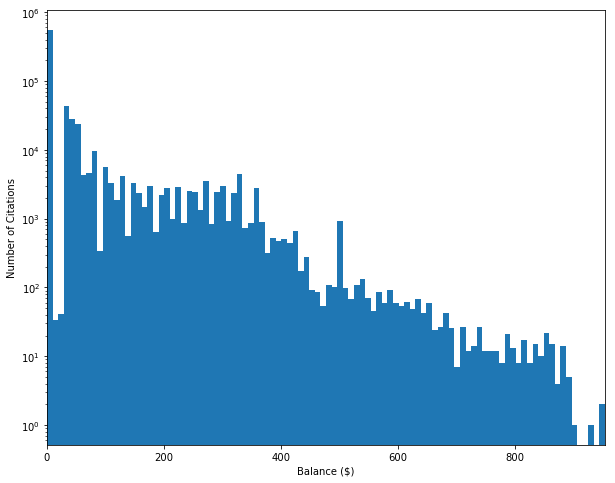

In [7]:
df['balance'].describe()
df['balance'][df['balance'] == 0].count()/df['balance'].count()*100

fig = plt.figure(figsize=(10, 8))
_ = plt.hist(df['balance'], bins=100)
_ = plt.xlabel('Balance ($)')
_ = plt.ylabel('Number of Citations')
_ = plt.yscale('log')
_ = plt.xlim([0, 954])

Findings:
- The minimum balance is \$0 and the maximum balance is \$954.
- 75% of balances are \$0. In other words, 75% of the accounts have been paid off.

count    742513.000000
mean         27.786176
std          45.704923
min           0.000000
25%           0.000000
50%          32.000000
75%          32.000000
max         502.000000
Name: open_fine, dtype: float64

42.996688273471307

76.844984532257342

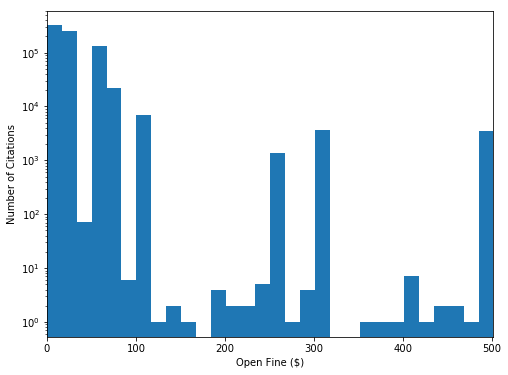

In [8]:
df['open_fine'].describe()
df['open_fine'][df['open_fine'] == 0].count()/df['open_fine'].count()*100
df['open_fine'][df['open_fine'] <= 32].count()/df['open_fine'].count()*100

fig = plt.figure(figsize=(8, 6))
_ = plt.hist(df['open_fine'], bins=30)
_ = plt.xlabel('Open Fine ($)')
_ = plt.ylabel('Number of Citations')
_ = plt.yscale('log')
_ = plt.xlim([0, 502])

Findings:
- The minimum open fine is \$0 and the maximum open fine is \$502. Since the maximum open fine is the same as the maximum fine, it seems reasonable to conclude that the account that received the citation for \$502 received just that one violation in the time period of the dataset.
- 43% of open fines are \$0, meaning the accounts have been paid off. 

count    742513.000000
mean          5.775903
std          25.420075
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         300.000000
Name: open_penalty, dtype: float64

93.004162890077353

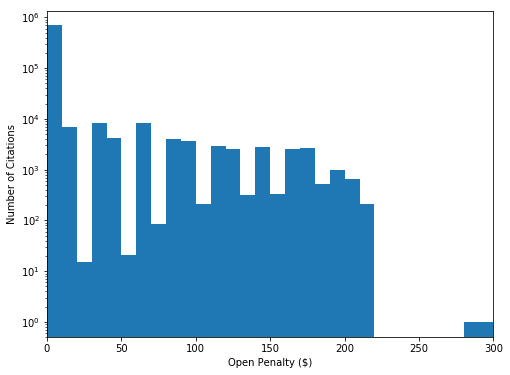

In [9]:
df['open_penalty'].describe()
df['open_penalty'][df['open_penalty'] == 0].count()/df['open_penalty'].count()*100
fig = plt.figure(figsize=(8, 6))
_ = plt.hist(df['open_penalty'], bins=30)
_ = plt.xlabel('Open Penalty ($)')
_ = plt.ylabel('Number of Citations')
_ = plt.yscale('log')
_ = plt.xlim([0, 300])

Findings: 
- The maximum open penalty is \$300. 
- 93% of open penalties are \$0, which suggests that these accounts were either paid on time and did not incur penalties or they have already paid off their penalties.


### (E) Volume of Citations

1016
7072
29701
247504


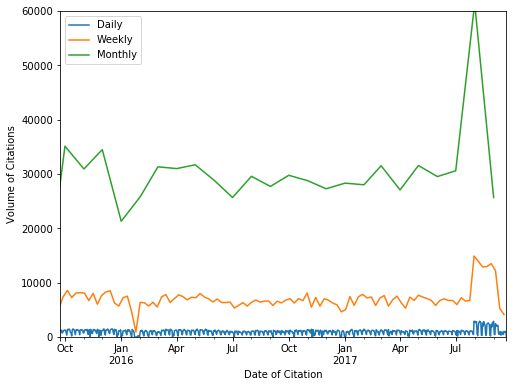

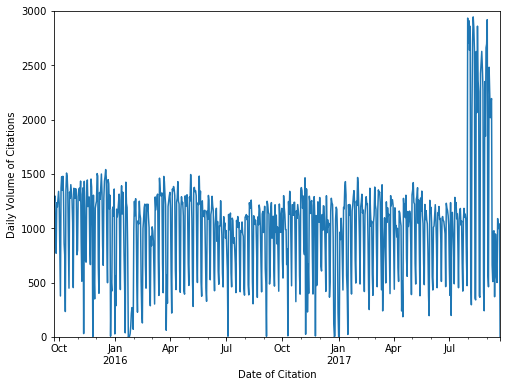

In [10]:
fig = plt.figure(figsize=(8, 6))
_ = df['citation'].resample('D').count().plot()
_ = df['citation'].resample('W').count().plot()
_ = df['citation'].resample('M').count().plot()
_ = plt.xlabel('Date of Citation')
_ = plt.ylabel('Volume of Citations')
_ = plt.legend(['Daily', 'Weekly', 'Monthly'])
_ = plt.xlim(['2015-09-23', '2017-09-22'])
_ = plt.ylim([0, 60000])

fig = plt.figure(figsize=(8, 6))
_ = df['citation'].resample('D').count().plot()
_ = plt.xlabel('Date of Citation')
_ = plt.ylabel('Daily Volume of Citations')
_ = plt.xlim(['2015-09-23', '2017-09-22'])
_ = plt.ylim([0, 3000])

print(round(df['citation'].resample('D').count().mean()))
print(round(df['citation'].resample('W').count().mean()))
print(round(df['citation'].resample('M').count().mean()))
print(round(df['citation'].resample('A').count().mean()))

Findings:
- The average daily volume of citations is: 1016. 
- The average weekly volume of citations is: 7072.
- The average monthly volume of citations is: 29,701.
- The average annual volume of citations is: 247,504

- The surge in citations in July 2017 is likely due to the City's fiscal year ending on June 30th. 

### (F) Average City Revenue from Citations

47872
333278
1399768
11664734


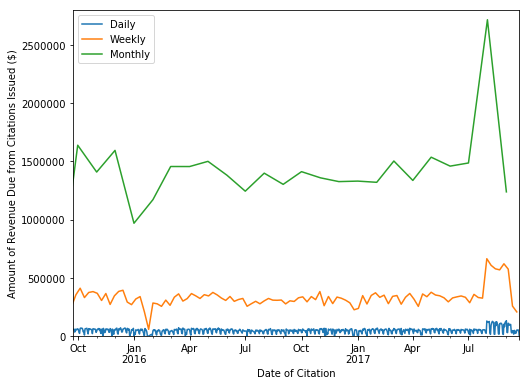

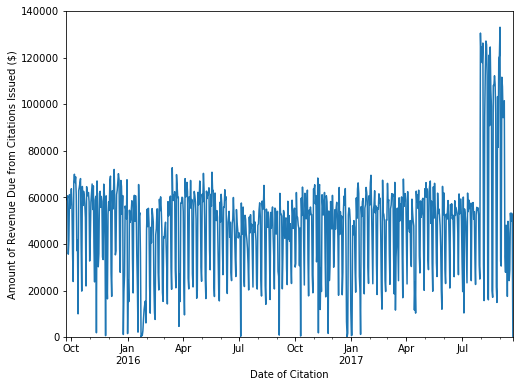

In [11]:
fig = plt.figure(figsize=(8, 6))
_ = df['fine'].resample('D').sum().plot()
_ = df['fine'].resample('W').sum().plot()
_ = df['fine'].resample('M').sum().plot()
_ = plt.xlabel('Date of Citation')
_ = plt.ylabel('Amount of Revenue Due from Citations Issued ($)')
_ = plt.legend(['Daily', 'Weekly', 'Monthly'])
_ = plt.xlim(['2015-09-23', '2017-09-22'])
_ = plt.ylim([0, 2800000])

print(round(df['fine'].resample('D').sum().mean()))
print(round(df['fine'].resample('W').sum().mean()))
print(round(df['fine'].resample('M').sum().mean()))
print(round(df['fine'].resample('A').sum().mean()))

fig = plt.figure(figsize=(8, 6))
_ = df['fine'].resample('D').sum().plot()
_ = plt.xlabel('Date of Citation')
_ = plt.ylabel('Amount of Revenue Due from Citations Issued ($)')
_ = plt.xlim(['2015-09-23', '2017-09-22'])
_ = plt.ylim([0, 140000])

Findings:
- The average daily revenue from citations is: \$47,872.
- The average weekly revenue from citations is: \$333,278.
- The average monthly revenue from citations is: \$1,399,768.
- The average annual revenue from citations is: \$11,664,734.


Based on the insights gained so far, the next questions I'd like to investigate are as follows:
1. Where geographically do the most offenses occur? Where are citations rare?
2. What percentage of the city's revenue is supplied by parking citations?
3. What period of day (lunch time, business hours, overnight, etc.) sees the most citations?
4. Does any one citation code have an interesting temporal trend?
5. Is there a relationship between in-state vehicles and certain times of violations (perhaps more common during working hours)? 
6. Is there a relationship between out-of-state vehicles and certain violation codes (perhaps unfamiliar with the signage)?
7. How common is it to have a repeat offender within the two year period the data covers?